<a href="https://colab.research.google.com/github/RaffaeleLeo/TextureSynthesisProject/blob/main/TextureSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adversarial GAN networks for texture synthesis

First we follow the tutorial given on cycle GANs

In [ ]:
!pip install pytorch-lightning==1.8.0
!pip install pyyaml==5.4.1

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# @title import dependencies

from typing import Sequence, List, Dict, Tuple, Optional, Any, Set, Union, Callable, Mapping
import itertools

import dataclasses
from dataclasses import dataclass
from dataclasses import asdict
from pathlib import Path
from pprint import pprint
from urllib.request import urlopen
import random

from PIL import Image
import PIL

import torchvision.utils
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.backends.cudnn as cudnn

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# @title reproducibility stuff

import random
np.random.seed(0)
random.seed(0)

torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

# This prevoius seeds should be redundant.
_ = pl.seed_everything(0)

INFO:lightning_lite.utilities.seed:Global seed set to 0


In [ ]:
class Dataset(Dataset):

    def __init__(self,
                 folder: Path,
                 transform: Optional[Callable] = None,
                 fixed_pairs: bool = False,
        ) -> None:
        """
        Dataset to handle unpaired images, i.e. the number of images in folder
        and in folderB may be different.

        :param folder: path to the folder that contains the A images
        :param tranform: tranform to apply to the images
        """
        super().__init__()
        self.folder: Path = Path(folder)

        if not (folder.is_dir()):
            raise RuntimeError(f"The folders are not valid!\n\t- Folder A: {folder}\n")

        self.files: List[Path] = list(sorted(folder.rglob('*.jpeg')))

        if not self.files:
            raise RuntimeError("Empty image lists for folder!")

        self.files_num: int = len(self.files)

        self.transform: Optional[Callable] = transform
        self.fixed_pairs: bool = fixed_pairs

    def __len__(self) -> int:
        """
        :returns: number of images used
        """
        return self.files_num

    def pil_loader(self, path: Path) -> PIL.Image:
        """ PIL loader implementation from the Pytorch's ImageDataset class
        https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder

        :param path: the path to an image
        :returns: an image converted into RGB format
        """
        # open path as file to avoid ResourceWarning
        # (https://github.com/python-pillow/Pillow/issues/835)
        with path.open('rb') as f:
            img = PIL.Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        """
        Returns the next image in the file

        :param index: index of the sample (not relevant)
        :returns: a dictionary containing:
                    - A: the image
                    - path: the path to the image
        """

        # Enforce a valid index for `files`
        files = self.files[index % self.files_num]

        image = self.pil_loader(files)


        if self.transform is not None:
            image = self.transform(image)

        return {
            'A': image,
            'A_path': str(files)
        }

In [ ]:
#@title visualization utility functions

def plot_images(images,
                images_per_row: int,
                border: float = 3.,
                pad_value: float = 1,
                title = 'Some images'):
    """
    Visualize many images in a nice grid

    :param images: the images to visualize
    :param images_per_row: number of images per row
    :param border: the border size of the grid
    :param pad_value: border color
    :param title: the title of plot
    """
    # Matplolib plot, much faster for static images
    # First visualise the original images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

In [ ]:
# @title hyperparameters
# The dataclass are fancy classes to hold data

# Working with dataclasses is particularly comfortable
# since you can specify types and get autocomplete/suggestion
# of the available hyperparameters

@dataclass
class Config:
    #dataset_name: str = "ukiyoe2photo"  # name of the dataset

    # Run we did:
    # map: 200 epochs, 100 decay
    # ukiyo: 40 epochs, 20 decay (due to time contraints)
    # They took ~7 hours each on a 2080ti
    n_epochs: int = 500  # number of epochs of training
    decay_epoch: int = 350  # epoch from which to start lr decay
    img_size: int = 256  # size of image

    lr_gan: int = 0.0001
    lr_dec: int = 0.0004

    batch_size: int = 2  # size of the batches
    lr: float = 0.0003  # adam: learning rate
    b1: float = 0.5  # adam: decay of first order momentum of gradient
    b2: float = 0.995  # adam: decay of first order momentum of gradient

    channels: int = 64  # number of image channels
    n_residual_blocks: int = 1  # number of residual blocks in generator # original 9

    noise_channels: int = 20
    depth: int = 4
    outputFolder: str = "/content/gdrive/MyDrive/Masters Semester 2/Texture Synthesis/Experimental Results/Forest_TTUR"
    nz: int = 96
    zx: int = 6
    beta1 = 0.5

opt = Config()
pprint(asdict(opt))

{'b1': 0.5,
 'b2': 0.995,
 'batch_size': 2,
 'channels': 64,
 'decay_epoch': 350,
 'depth': 4,
 'img_size': 256,
 'lr': 0.0003,
 'lr_dec': 0.0004,
 'lr_gan': 0.0001,
 'n_epochs': 500,
 'n_residual_blocks': 1,
 'noise_channels': 20,
 'nz': 96,
 'outputFolder': '/content/gdrive/MyDrive/Masters Semester 2/Texture '
                 'Synthesis/Experimental Results/Forest_TTUR',
 'zx': 6}


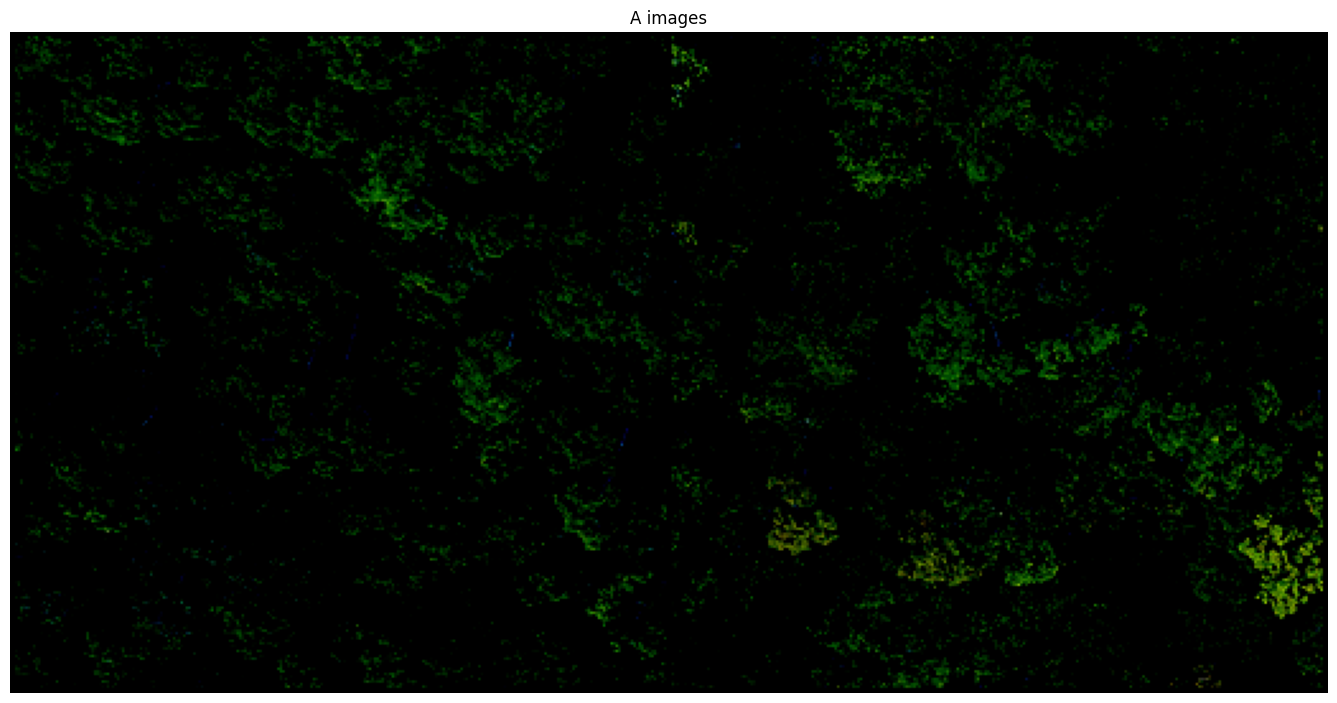

In [ ]:

train = Path(f"gdrive/My Drive/Masters Semester 2/Texture Synthesis/dtd/images/forest_texture")


visualize_batch_idx = 1


import torchvision.utils
import matplotlib.pyplot as plt

canonicT = [transforms.RandomCrop(256),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
mirrorT = [transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip()]
transformTex=transforms.Compose(mirrorT+canonicT)

loader = DataLoader(
    Dataset(
        train,
        transform=transformTex,
        fixed_pairs=True,
    ),
    batch_size=opt.batch_size,
    shuffle=False,
)

load_iter = iter(loader)

for _ in range(visualize_batch_idx):
    batch = next(load_iter)


plot_images(batch["A"], images_per_row=2, border=2, pad_value=0, title="A images")

In [ ]:
#@title generate noise input

def setNoise(noise):
    noise=noise.detach()*1.0
    noise.uniform_(-1, 1)
    return noise

In [ ]:
# @title Generator
class Generator_SGAN4(nn.Module):

    def __init__(self, noise_channels=20):
      super(Generator_SGAN4, self).__init__()
      '''
      # :param ngf is channels of first layer, doubled up after every stride operation, or halved after upsampling
      # :param nDep is depth, both of decoder and of encoder
      # :param nz is dimensionality of stochastic noise we add
      '''
      in_features = noise_channels
      layers = []

      # Use upsampling to get a stride of 1/2
      # Initial convolution block
      out_features = 256
      model = [
          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.Conv2d(in_features, out_features,  5, 1, 2),
          nn.BatchNorm2d(out_features),
          nn.ReLU(inplace=True),
      ]
      in_features = out_features

      # layer 2, half the output channels for each layer
      # we keep a stride of 1/2 for each layer so we continue to upsample
      out_features = out_features // 2
      model += [
          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.Conv2d(in_features, out_features,  5, 1, 2),
          nn.BatchNorm2d(out_features),
          nn.ReLU(),
      ]
      in_features = out_features
      # layer 3
      out_features = out_features // 2
      model += [
          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.Conv2d(in_features, out_features,  5, 1, 2),
          nn.BatchNorm2d(out_features),
          nn.ReLU(),
      ]
      in_features = out_features

      # output layer
      # output features are always 3 for the image
      # here we foregoe batch norm and add a tanh() function or the output
      # as per the origional sgan paper
      out_features = 3
      model += [
          nn.Upsample(scale_factor=2, mode='nearest'),
          nn.Conv2d(in_features, out_features,  5, 1, 2),
          nn.Tanh(),
      ]

      self.G = nn.Sequential(*model)

    def forward(self, input):
        return self.G(input)

In [ ]:
# @title Discriminator
class Discriminator_SGAN4(nn.Module):
    def __init__(self):
        super(Discriminator_SGAN4, self).__init__()

        # No batch norm for the input and output layers as per the paper
        # input channels is always 3
        # we expand from 64 channels until we run out of layers
        # discriminator uses a stride of 2
        in_features = 3
        out_features = 64
        model = [
            nn.Conv2d(in_features, out_features,  5, 2, 2),
            nn.LeakyReLU(0.2),
        ]
        in_features = out_features

        # layer 2
        # for the middle layser just double the output each time and apply batchnorm
        out_features = out_features * 2
        model += [
            nn.Conv2d(in_features, out_features,  5, 2, 2),
            nn.BatchNorm2d(out_features),
            nn.LeakyReLU(0.2),
        ]
        in_features = out_features

        # layer 3
        out_features = out_features * 2
        model += [
            nn.Conv2d(in_features, out_features,  5, 2, 2),
            nn.BatchNorm2d(out_features),
            nn.LeakyReLU(0.2),
        ]
        in_features = out_features

        # output layer 4
        # output channels are always 1 for the discriminator
        # here we foregoe batch norm and add a sigmoid() function for the output
        out_features = 3
        model += [
            nn.Conv2d(in_features, out_features,  5, 2, 2),
            nn.Sigmoid(),
        ]

        self.main = nn.Sequential(*model)

    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
# @title initialize the weights
def weights_init_normal(m: nn.Module) -> None:
        """
        Initialize the weights with a gaussian N(0, 0.02)

        :param m: the module that contains the weights to initialise
        """
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
            if hasattr(m, "bias") and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

# experiments

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), requires_grad=False, device=device)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size: int = 5) -> None:
        """
        Image buffer to increase the robustness of the generator.

        Once it is full, i.e. it contains max_size images, each image in a given batch
        is swapped with probability p=0.5 with another one contained in the buffer.

        """
        assert (
            max_size > 0
        ), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data: torch.Tensor) -> torch.Tensor:
        """
        Fill the buffer with each element in data.
        If the buffer is full, with p=0.5 swap each element in data with
        another in the buffer.

        :param data: tensor with shape [batch, ...]

        :returns: tensor with shape [batch, ...]
        """
        to_return = []

        for i in range(data.shape[0]):
            element = data[[i], ...]

            if len(self.data) < self.max_size:
                self.data.append(element)

            elif random.uniform(0, 1) > 0.5:
                i = random.randint(0, self.max_size - 1)
                self.data[i], element = element, self.data[i]

            to_return.append(element)

        return torch.cat(to_return)


In [ ]:
class LambdaLR:
    def __init__(self, n_epochs: int, decay_start_epoch: int) -> None:
        """
        Linearly decay the leraning rate to 0, starting from `decay_start_epoch`
        to the final epoch.

        In practice

        :param n_epochs: total number of epochs
        :param decay_start_epoch: epoch in which the learning rate starts to decay
        """
        assert (
            n_epochs - decay_start_epoch
        ) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch: int) -> float:
        """
        One step of lr decay:
        - if `epoch < self.decay_start_epoch` it doesn't change the learning rate.
        - Otherwise, it linearly decay the lr to reach zero

        :param epoch: current epoch
        :returns: learning rate multiplicative factor
        """
        return 1.0 - max(0, epoch - self.decay_start_epoch) / (
            self.n_epochs - self.decay_start_epoch
        )

In [ ]:
def noisy_labels(size, p_flip=0.05):  # p_flip is the probability of label flipping
    # Create labels with p_flip chance of being flipped
    noisy_labels = (torch.rand(size) > p_flip).float()  # Flips with probability p_flip
    noisy_labels[noisy_labels == 0.0] = 0.1  # Replace 0 with 0.1 for fake
    noisy_labels[noisy_labels == 1.0] = 0.9  # Replace 1 with 0.9 for real
    return noisy_labels

a = noisy_labels([3,3,3], 0.1)
print(a)

tensor([[[0.9000, 0.9000, 0.1000],
         [0.9000, 0.9000, 0.9000],
         [0.9000, 0.9000, 0.9000]],

        [[0.9000, 0.9000, 0.9000],
         [0.9000, 0.9000, 0.9000],
         [0.9000, 0.9000, 0.9000]],

        [[0.9000, 0.9000, 0.9000],
         [0.9000, 0.9000, 0.9000],
         [0.9000, 0.9000, 0.9000]]])


# quantitative results

In [ ]:
!pip install scikit-image

In [ ]:
from skimage.metrics import structural_similarity as ssim
import torch

def calculate_ssim_batch(batch1, batch2, window_size):
    ssim_scores = []

    # Iterate over each image pair in the batches
    for image1, image2 in zip(batch1, batch2):
        # Convert tensors to numpy arrays if they are PyTorch tensors
        if isinstance(image1, torch.Tensor):
            image1 = image1.permute(1, 2, 0).cpu().detach().numpy()
        if isinstance(image2, torch.Tensor):
            image2 = image2.permute(1, 2, 0).cpu().detach().numpy()

        # Ensure the window size is appropriate
        min_size = min(image1.shape[0], image1.shape[1], window_size)
        if min_size % 2 == 0:  # Make sure it's odd
            min_size -= 1

        # Compute SSIM for the current pair
        ssim_value = ssim(image1, image2, multichannel=True, win_size=min_size, channel_axis=-1)
        ssim_scores.append(ssim_value)

    # Return the average SSIM score for the batch
    return np.mean(ssim_scores)


In [ ]:
import torch
import numpy as np

def calculate_psnr_batch(batch1, batch2):
    psnr_scores = []

    # Iterate over each image pair in the batches
    for image1, image2 in zip(batch1, batch2):
        # Ensure the images are torch tensors
        if not isinstance(image1, torch.Tensor):
            image1 = torch.tensor(image1)
        if not isinstance(image2, torch.Tensor):
            image2 = torch.tensor(image2)

        # Calculate MSE
        mse = torch.mean((image1 - image2) ** 2)
        if mse == 0:
            psnr_scores.append(float('inf'))
            continue

        # Assuming the pixel values are in the range [0, 1]
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        psnr_scores.append(psnr.item())

    # Return the average PSNR score for the batch
    return np.mean(psnr_scores)


# training the network

In [ ]:
from __future__ import print_function
import random
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import sys
import pandas as pd
import time

# I use binary cross entropy as the loss funcion as suggested by the paper
loss = nn.BCELoss()

# Define the size to which images will be resized
# resize_to = (height, width)
# resize_transform = Resize(resize_to)

N=0
# Initialize both netoworks
Descriminator_network = Discriminator_SGAN4()
Generator_Network = Generator_SGAN4(opt.noise_channels)

# put both on device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("device",device)

Generator_Network.apply(weights_init_normal)
Generator_Network = Generator_Network.to(device)
print(Generator_Network)
Descriminator_network.apply(weights_init_normal)
Descriminator_network = Descriminator_network.to(device)
print(Descriminator_network)

# the size of the input noise found by using the image size and the depth of
# the networks as described in the paper

NZ = opt.img_size//2**opt.depth
print('length and width of noise: ', NZ)

# for training
noise = torch.FloatTensor(opt.batch_size, opt.noise_channels, NZ,NZ)



noise=noise.to(device)

# setup optimizer, I am using Adam as was suggested in the paper
optimizerD = optim.Adam(Descriminator_network.parameters(), lr=opt.lr_dec, betas=(opt.beta1, 0.999))
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(
            optimizerD,
            lr_lambda=LambdaLR(opt.n_epochs, opt.decay_epoch).step,
        )
optimizerG = optim.Adam(Generator_Network.parameters(), lr=opt.lr_gan, betas=(opt.beta1, 0.999))
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
            optimizerG,
            lr_lambda=LambdaLR(opt.n_epochs, opt.decay_epoch).step,
        )
Generator_Network.train()
Descriminator_network.train()

fake_buffer = ReplayBuffer()

fixed_noise=setNoise(noise)

training_data = []

img_list = []

for epoch in range(opt.n_epochs):
  for i, data in enumerate(loader, 0):
    t0 = time.time()
    sys.stdout.flush()

    # train Descriminator with real
    Descriminator_network.zero_grad()
    real = data['A'].to(device)
    output_real = Descriminator_network(real)
    real_label = noisy_labels(output_real.shape, 0.05).to(device)
    errD_real = loss(output_real, output_real.detach()*0+real_label)
    errD_real.backward()

    # train Descriminator with fake
    noise=setNoise(noise)
    fake = Generator_Network(noise)
    output_fake = Descriminator_network(fake_buffer.push_and_pop(fake.detach()))
    fake_label = torch.tensor(0.1).to(device)
    errD_fake = loss(output_fake, output_fake.detach()*0+fake_label)
    errD_fake.backward()
    optimizerD.step()
    errD = errD_real + errD_fake
    Descriminator_network.zero_grad()
    Generator_Network.zero_grad()

    # now train the Generator
    noise=setNoise(noise)
    fake = Generator_Network(noise)
    output = Descriminator_network(fake)
    #output = Descriminator_network(fake)
    loss_adv = loss(output, output.detach()*0+real_label)
    errG = loss_adv

    errG.backward()
    optimizerG.step()
    if i % 50 == 0:  # Print every 50 mini-batches
         print('[%d/%d][%d/%d]\tLoss_D_real: %.4f\tLoss_D_fake: %.4f\tLoss_D_total: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opt.n_epochs, i, len(loader),
                     errD_real.item(), errD_fake.item(), errD.item(), errG.item(),
                     output_real.mean().item(), output_fake.mean().item(), output.mean().item()))

    training_data.append({
            'epoch': epoch,
            'batch': i,
            'Loss_D_real': errD_real.item(),
            'Loss_D_fake': errD_fake.item(),
            'Loss_D_total': errD.item(),
            'Loss_G': errG.item(),
            'D(x)': output_real.mean().item(),
            'D(G(z))_real': output_fake.mean().item(),
            'D(G(z))_fake': output.mean().item()
        })

  # save the images every 5 epocs so we can check on progress
  if epoch % 5 == 0:
    Generator_Network.eval()
    with torch.no_grad():
        # Generate a batch of images
        noise = setNoise(noise)
        fake_fixed = Generator_Network(fixed_noise).detach().cpu()
        fake_images = Generator_Network(noise)
        real_images = next(iter(loader))['A']

        # Ensure both tensors are on the same device and have the same dimensions
        fake_images = fake_images.to(device)
        real_images = real_images.to(device)

        # Calculate SSIM and PSNR
        ssim_value = calculate_ssim_batch(fake_images, real_images, 256)
        psnr_value = calculate_psnr_batch(fake_images, real_images)

        print(f'Epoch {epoch}: SSIM = {ssim_value}, PSNR = {psnr_value}')
    img_list.append(vutils.make_grid(fake_fixed, padding=2, normalize=True))
    # Set the Generator back to train mode
    Generator_Network.train()

    vutils.save_image(fake,'%s/generated_textures_%03d.jpg' % (opt.outputFolder, epoch),normalize=True)

  lr_scheduler_D.step(epoch)
  lr_scheduler_G.step(epoch)


# also save the real image at the end so we can compare results
vutils.save_image(real,    '%s/real_textures.jpg' % opt.outputFolder,  normalize=True)

# when we are finished training try generating a single large image using the
# generator in eval mode
Generator_Network.eval()
large_single_noise = torch.FloatTensor(1, opt.noise_channels, NZ*4,NZ*4)
large_single_noise=setNoise(large_single_noise)
large_single_noise=large_single_noise.to(device)

with torch.no_grad():
    fakeBig=Generator_Network(large_single_noise)

df = pd.DataFrame(training_data)
df.to_csv('/content/gdrive/MyDrive/Masters Semester 2/Texture Synthesis/Experimental Results/Baseline Model/training_data.csv', index=False)
vutils.save_image(fakeBig,'%s/final_big_texture.jpg' % (opt.outputFolder),normalize=True)

device cuda:0
Generator_SGAN4(
  (G): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(20, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Upsample(scale_factor=2.0, mode='nearest')
    (13): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (14): Tanh()
  )
)
Discriminator_SGAN4(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5

<ipython-input-141-b7a4d44c2b5d>:21: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(image1, image2, multichannel=True, win_size=min_size, channel_axis=-1)


Epoch 0: SSIM = 0.024469591677188873, PSNR = 8.12779712677002
[1/500][0/16]	Loss_D_real: 0.6749	Loss_D_fake: 0.4168	Loss_D_total: 1.0917	Loss_G: 0.6847	D(x): 0.5514	D(G(z)): 0.2201 / 0.5504
[2/500][0/16]	Loss_D_real: 0.8476	Loss_D_fake: 0.4515	Loss_D_total: 1.2991	Loss_G: 0.6578	D(x): 0.4550	D(G(z)): 0.2371 / 0.5677
[3/500][0/16]	Loss_D_real: 0.4322	Loss_D_fake: 0.3610	Loss_D_total: 0.7932	Loss_G: 1.2613	D(x): 0.7999	D(G(z)): 0.1592 / 0.2708
[4/500][0/16]	Loss_D_real: 0.5280	Loss_D_fake: 0.4527	Loss_D_total: 0.9807	Loss_G: 1.2764	D(x): 0.6698	D(G(z)): 0.2916 / 0.2576
[5/500][0/16]	Loss_D_real: 0.5889	Loss_D_fake: 0.3771	Loss_D_total: 0.9660	Loss_G: 0.9386	D(x): 0.6185	D(G(z)): 0.1924 / 0.3839
Epoch 5: SSIM = 0.0208149217069149, PSNR = 6.750762224197388
[6/500][0/16]	Loss_D_real: 0.5939	Loss_D_fake: 0.6473	Loss_D_total: 1.2412	Loss_G: 1.4556	D(x): 0.7263	D(G(z)): 0.3689 / 0.2743
[7/500][0/16]	Loss_D_real: 0.4382	Loss_D_fake: 0.7424	Loss_D_total: 1.1805	Loss_G: 1.8360	D(x): 0.8333	D(G(z)

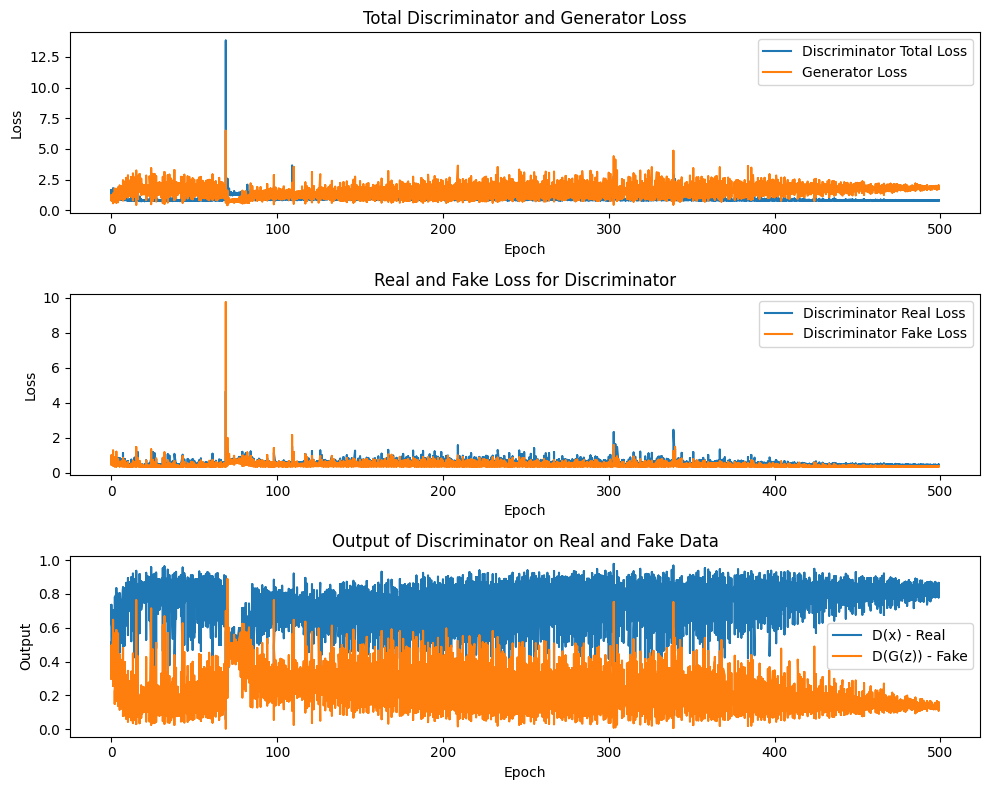

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your data is in a DataFrame `df`
df = pd.read_csv('/content/gdrive/MyDrive/Masters Semester 2/Texture Synthesis/Experimental Results/Baseline Model/training_data.csv')


# Plotting
plt.figure(figsize=(10, 8))

# Total Discriminator and Generator Loss
plt.subplot(3, 1, 1)
plt.plot(df['epoch'], df['Loss_D_total'], label='Discriminator Total Loss')
plt.plot(df['epoch'], df['Loss_G'], label='Generator Loss')
plt.title('Total Discriminator and Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Real and Fake Loss for Discriminator
plt.subplot(3, 1, 2)
plt.plot(df['epoch'], df['Loss_D_real'], label='Discriminator Real Loss')
plt.plot(df['epoch'], df['Loss_D_fake'], label='Discriminator Fake Loss')
plt.title('Real and Fake Loss for Discriminator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Output of Discriminator on Real and Fake Data
plt.subplot(3, 1, 3)
plt.plot(df['epoch'], df['D(x)'], label='D(x) - Real')
plt.plot(df['epoch'], df['D(G(z))_fake'], label='D(G(z)) - Fake')
plt.title('Output of Discriminator on Real and Fake Data')
plt.xlabel('Epoch')
plt.ylabel('Output')
plt.legend()

plt.tight_layout()
plt.show()

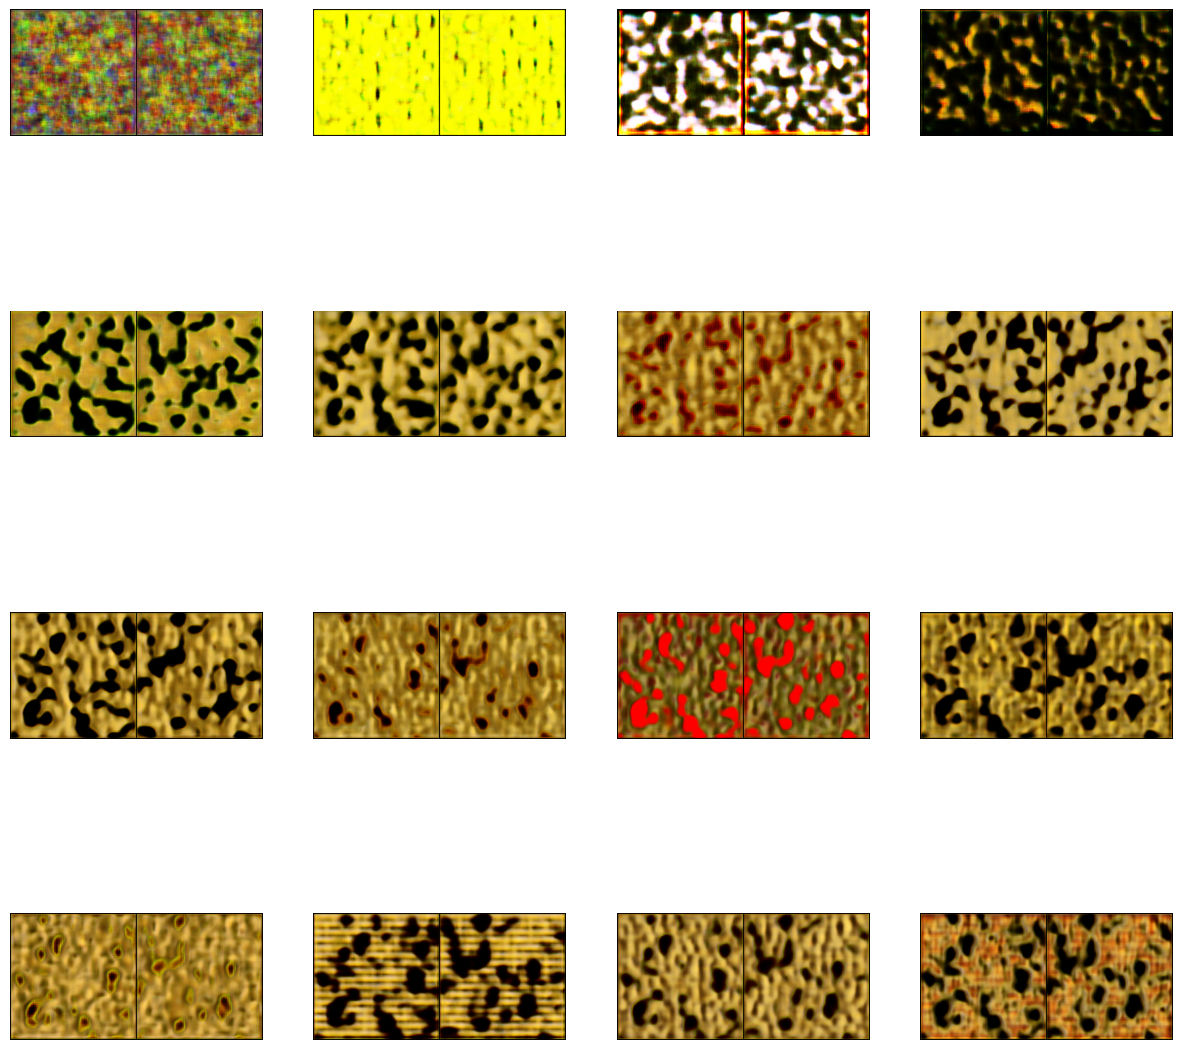

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the number of images you want to display
num_images_to_display = min(len(img_list), 16)  # for example, show 16 images

# Set the size of the plot
plt.figure(figsize=(15,15))

# Loop through the selected number of items in img_list and add each as a subplot
for i, img in enumerate(img_list[:num_images_to_display]):
    plt.subplot(4, 4, i + 1)  # Assuming you want a 4x4 grid of images
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # Transpose the tensor to image format
    plt.axis('off')  # Turn off axis numbers/labels

plt.show()

Gradient Penalty
Gradient penalty is often used in Wasserstein GANs (WGAN-GP) to enforce the Lipschitz constraint, which helps in stabilizing the training process.

In [ ]:
# big image
Generator_Network.eval()
large_single_noise = torch.FloatTensor(1, opt.noise_channels, NZ*20,NZ*20)
large_single_noise=setNoise(large_single_noise)
large_single_noise=large_single_noise.to(device)
with torch.no_grad():
    fakeBig=Generator_Network(large_single_noise)

vutils.save_image(fakeBig,'%s/big_texture_%03d.jpg' % (opt.outputFolder, epoch),normalize=True)
Generator_Network.train()

Generator_SGAN4(
  (G): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(20, 256, kernel_size=(5, 5), stride=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Upsample(scale_factor=2.0, mode='nearest')
    (13): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1))
    (14): Tanh()
  )
)